<a href="https://colab.research.google.com/github/vujjiniashrith/ESS-profit-maximization-using-deep-Reinforcement-Learning/blob/main/DQN_openai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import random


In [ ]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
# !pip install seaborn

In [ ]:
# import tensorflow as tf

# # Force CPU-only execution (useful if you have GPU-related issues)
# tf.config.set_visible_devices([], 'GPU')

In [ ]:
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box


In [ ]:
data_elec = pd.read_csv("electicity_data_hourly.csv")
data_cons = pd.read_csv("consumer_data_hourly.csv")

In [ ]:
print(data_elec.columns)

Index(['datetime', 'system_energy_price_da'], dtype='object')


In [ ]:
print(data_cons.columns)

Index(['dateTime', 'use'], dtype='object')


In [ ]:
data_elec.head(6)

,datetime,system_energy_price_da
0,2022-01-01 00:00:00,21.02
1,2022-01-01 01:00:00,18.43
2,2022-01-01 02:00:00,18.11
3,2022-01-01 03:00:00,18.15
4,2022-01-01 04:00:00,17.70
5,2022-01-01 05:00:00,17.67


In [ ]:
data_elec.rename(columns={'system_energy_price_da':'price'},inplace = True)

In [ ]:
data_elec.head()

,datetime,price
0,2022-01-01 00:00:00,21.02
1,2022-01-01 01:00:00,18.43
2,2022-01-01 02:00:00,18.11
3,2022-01-01 03:00:00,18.15
4,2022-01-01 04:00:00,17.70


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
data_elec['price'] = scaler.fit_transform(data_elec[['price']])

In [ ]:
data_elec.head()

,datetime,price
0,2022-01-01 00:00:00,0.016487
1,2022-01-01 01:00:00,0.010621
2,2022-01-01 02:00:00,0.009897
3,2022-01-01 03:00:00,0.009987
4,2022-01-01 04:00:00,0.008968


In [ ]:
data_cons.rename(columns={'use':'usage'},inplace = True)

In [ ]:
data_cons.head()

,dateTime,usage
0,2016-01-01 00:00:00,2.108533
1,2016-01-01 01:00:00,1.852600
2,2016-01-01 02:00:00,1.988000
3,2016-01-01 03:00:00,1.993267
4,2016-01-01 04:00:00,1.781533


In [ ]:
print(data_cons.usage.max()," ",data_cons.usage.min())
print(data_elec.price.max()," ",data_elec.price.min())

29.8692   0.0
1.0   0.0


In [ ]:
print(data_cons.usage.median(), " ", data_cons.usage.mean())

3.519333333333332   5.361010481177898


In [ ]:
data_elec.shape

(8737, 2)

In [ ]:
data_cons.shape

(8784, 2)

In [ ]:
split_point = 7027
train_elec = data_elec[:split_point]
train_cons = data_cons[:split_point]
test_elec = data_elec[split_point:]
test_cons = data_cons[split_point:]
print(train_elec.shape, test_elec.shape)
print(train_cons.shape, test_cons.shape)

(7027, 2) (1710, 2)
(7027, 2) (1757, 2)


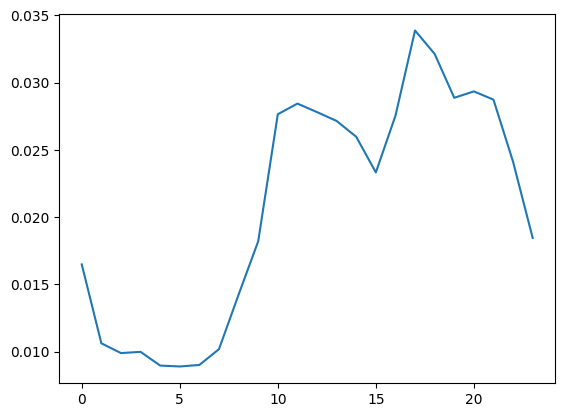

In [ ]:
plt.plot(data_elec.price[:24])

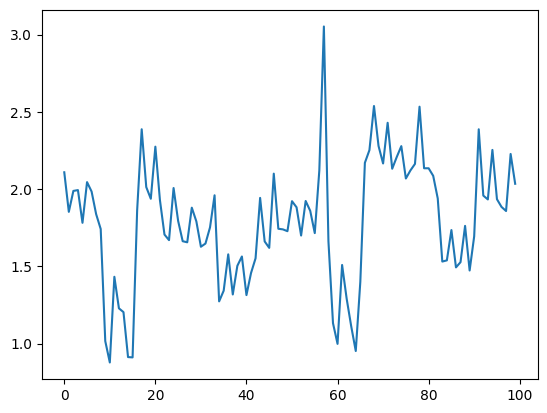

In [ ]:
plt.plot(data_cons.usage[0:100])

In [ ]:
data_usage = data_cons['usage'].values

In [ ]:
data_price = data_elec['price'].values

# Create Custom Environment of SmartGrid

In [ ]:
class SmartGrid(Env):
    def __init__(self,data_usage,data_price):
        #load electricity price data

        self.data_price = data_price

        #load consumer price data
        self.data_usage = data_usage

        #set maximum battery capacity
        self.max_capacity = 10

        #Actions that we can take
        #0 == -3, 1 == -2, 2 == -1, 3 ==0 , 4 == 1, 5 == 2, 6== 3 total 7 actions to take
        #-ve values stand for discharge and positive values stand for charge
        self.action_space = Discrete(7)

        #state
        self.observation_space = Box(low=np.array([0]), high=np.array([10]))

        #set initial start state
        self.state = 0

        #set initial position
        self.time_step = 0

        #initiate profits
        self.profits =0



        #current capacity
        self.current_capacity = []

        #action history
        self.action_history = []

        #profits history
        self.profits_history = []

        #rewards history
        self.reward_history = []


    def step(self,action):
        reward = 0

        reward = self.custom_reward(action)
        reward += self.punishment_for_bad_choices( action)

        self.reward_history.append(reward)
        self.action_history.append(action - 3)  # Store the action in action_history
        self.profits_history.append(self.profits)
        self.current_capacity.append(self.state);

        if self.time_step > 100:
            done = True
        else:
            done = False

        self.state += action - 3


        info = {}
        self.time_step += 1

        return self.state, reward, done, info

    def custom_reward(self,action):
        reward = 0

        # Calculate the change in profits due to the current action
        prev_profits = self.profits
        self.profits += (3 - action) * self.data_price[self.time_step]
        profit_change = self.profits - prev_profits

            # Define the reward based on the action type
        if action < 3:
            # rewarding for buying
            reward = -1 * profit_change*10
        elif action ==0:
            reward = 0
        else:
            # penalizing for selling
            reward = -1 * profit_change*2

        return -reward



    def punishment_for_bad_choices(self, action):
        punishment = 0

        #criteria for bad choices and assign a punishment
        if action == 1 or action == 0 or action == 2:
            if self.state < 3 - action:
                # Penalize actions that attempt to discharge more than available
                punishment = -5
        elif action == 4 or action == 5 or action == 6:
            if self.state > self.max_capacity - (action - 3):
                # Penalize actions that attempt to charge beyond capacity
                punishment = -5

        #punishment for storing the energy after horizon
#         if(self.time_step == 24):
#             if(self.state != 0):
#                 punishment = -10

        return punishment

    def render(self):
        #implement vizualization
        pass
    def reset(self):
        #reset the initial timestamp
        self.time_step =0
        self.profits = 0

        #empty the entire battery
        self.state = 0
        #set done state as false
        self.action_history = []
        self.profits_history = []
        self.reward_history = []
        self.current_capacity=[]

        return self.state
    def get_action_history(self):
        return self.action_history

    def get_time_step(self):
        return self.time_step
    def get_reward_history(self):
        return self.reward_history

    def get_profits_history(self):
        return self.profits_history
    def get_current_capacity(self):
        return self.current_capacity


In [ ]:
env = SmartGrid(data_usage,data_price)

/home/pratyush/.local/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
env.observation_space.sample()

array([1.4659163], dtype=float32)

In [ ]:
print(env.observation_space.shape)

(1,)


In [ ]:
data_elec.price[:6].values

array([0.016487  , 0.01062143, 0.00989673, 0.00998732, 0.0089682 ,
       0.00890026])

In [ ]:
episodes = 10
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:

        action = env.action_space.sample()
        n_state , reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode,score))
    action_history = env.get_action_history()
    print(action_history)
    #print(env.get_profits_history())
    print(env.get_reward_history())
    print(len(action_history),env.get_time_step())


Episode:1 Score:-181.82593532022827
[-2, -3, 2, 2, -3, 0, -2, -3, 0, -1, 3, 3, 3, -1, -2, 2, -3, -3, -2, -2, 0, -2, 2, -1, -1, 2, -3, 2, -3, -3, -3, 2, 3, 3, 0, -3, -3, 0, 1, 0, 3, -1, -2, -1, 2, 3, 3, 2, 2, 1, 1, -1, 1, -1, -3, -1, -1, 1, 0, -3, -1, 3, -2, 0, 0, 2, 2, 3, -1, 2, 1, -2, 3, 3, 3, -3, 2, 0, 2, -3, -2, 0, 1, 2, 1, -2, 0, -1, -2, 2, 0, 3, 1, -1, 0, -3, -1, 0, -3, -3, -2, 2]
[-4.670259987317692, -4.6813570069752695, -0.03958691910499139, -0.039949270767279624, -4.730953890750974, 0.0, -4.819730048011595, -4.694265784944289, 0.0, -4.817918289700154, -0.1659117673702328, -0.17066763293776613, -0.16686294048373945, -4.728462723072742, -4.480478304194221, -0.09330555303922457, -4.173838209982788, -3.983603587281457, -4.357278739016215, -4.4225020382281, 0.0, -4.425219675695262, -0.09647613008424677, -4.815427122021922, -4.814521242866202, -0.06323036506929974, -4.532566355648156, -0.061599782589002616, -4.554986864752242, -4.518298758945557, -4.490442974907147, -0.07645620074282

# Creating Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
!

In [ ]:
del model

In [ ]:
print(states)
print(actions)

(1,)
7


In [ ]:
def build_model(states, actions):
    model = Sequential()

    model.add(Dense(24, activation='relu', input_shape=(1,)))  # Use input_shape as a tuple with a single integer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                48        
                                                                 
 dense_9 (Dense)             (None, 64)                1600      
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dense_11 (Dense)            (None, 7)                 175       
                                                                 
Total params: 3,383
Trainable params: 3,383
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

In [ ]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.2)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-4,gamma = 0.99)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-5), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 8:42 - reward: -4.5054

/home/pratyush/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   42/10000 [..............................] - ETA: 1:59 - reward: -0.4866

/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/home/pratyush/.local/lib/python3.8/site-packages/rl/memory.py:38: DeprecationWarning: This function is deprecat

10000/10000 [==============================] - 46s 5ms/step - reward: 0.1036
98 episodes - episode_reward: 10.614 [-122.331, 54.209] - loss: 1.264 - mae: 0.352 - mean_q: 0.507

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 45s 4ms/step - reward: 0.4421
98 episodes - episode_reward: 45.065 [19.319, 58.585] - loss: 0.589 - mae: 0.749 - mean_q: 1.195

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 45s 4ms/step - reward: 0.1709
98 episodes - episode_reward: 17.482 [-91.285, 56.628] - loss: 0.526 - mae: 1.534 - mean_q: 2.135

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 45s 4ms/step - reward: 0.2113
98 episodes - episode_reward: 21.541 [-135.043, 54.285] - loss: 0.588 - mae: 2.042 - mean_q: 2.768

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 45s 5ms/step - reward: 0.3135
98 episodes - episode_reward: 31.932 [-87.923, 55.918] - loss: 0.612 - mae: 2.

In [ ]:
print(env.get_action_history())

[2, 3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3, 3, -3]


In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 60.521, steps: 102
Episode 2: reward: 60.521, steps: 102
Episode 3: reward: 60.521, steps: 102
Episode 4: reward: 60.521, steps: 102
Episode 5: reward: 60.521, steps: 102
Episode 6: reward: 60.521, steps: 102
Episode 7: reward: 60.521, steps: 102
Episode 8: reward: 60.521, steps: 102
Episode 9: reward: 60.521, steps: 102
Episode 10: reward: 60.521, steps: 102
60.52065404475043


In [ ]:
print(env.get_profits_history())

[-0.03297400126823082, -0.06483830057070389, -0.09452848989944743, -0.0645665368239877, -0.09147114774889031, -0.06477035963402483, -0.09181085243228554, -0.061237430926714395, -0.10397228009783498, -0.04934776700788117, -0.13230365069299757, -0.04696983422411451, -0.13040130446598425, -0.04894012138780687, -0.12686837575867382, -0.056889210979255395, -0.13950538998097656, -0.037865748709122224, -0.1342739378566899, -0.04764924359090496, -0.13570069752694988, -0.049483648881239226, -0.12184074644442429, -0.06646888305100097, -0.12211251019114049, -0.07468973638916566, -0.12143310082435001, -0.07523326388259803, -0.11973457740737381, -0.0715644533019295, -0.12252015581121475, -0.06517800525409907, -0.13563275659027083, -0.047513361717546845, -0.13841833499411177, -0.04540719268049641, -0.13753510281728415, -0.04656218860404021, -0.1368556934504937, -0.04513542893378024, -0.15934414349125825, 0.012682308180088808, -0.14983241235619163, 0.011867016939940273, -0.14752242050910402, 0.010236

In [ ]:
print(env.get_reward_history())

[-0.06594800253646164, -0.06372859860494613, -0.059380378657487076, 0.29961953075459724, -0.05380922184980522, 0.2670078811486548, -0.054080985596521414, 0.3057342150557114, -0.08546969834224116, 0.5462451308995381, -0.1659117673702328, 0.8533381646888306, -0.16686294048373948, 0.8146118307817738, -0.1558565087417339, 0.6997916477941843, -0.16523235800344233, 1.0163964127185434, -0.19281637829513534, 0.8662469426578494, -0.17610290787208985, 0.8621704864571066, -0.14471419512637013, 0.5537186339342332, -0.11128725428027902, 0.4742277380197482, -0.09348672887036868, 0.46199836941751976, -0.08900262704955156, 0.4817012410544431, -0.10191140501857052, 0.5734215055711568, -0.1409095026723435, 0.8811939487272398, -0.18180994655312985, 0.9301114231361536, -0.18425582027357548, 0.9097291421324394, -0.18058700969290697, 0.9172026451671346, -0.22841742911495602, 1.7202645167134705, -0.3250294410725609, 1.616994292961319, -0.3187788748980886, 1.5775885496874715, -0.309131261889664, 1.08841380559

In [ ]:
print(env.get_current_capacity())

[0, 2, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8, 5, 8]


In [ ]:
capacity_history = env.get_current_capacity()

In [ ]:
profit_history = env.get_profits_history()

In [ ]:
net_profit = profit_history[-1] + capacity_history[-1]*data_elec.price[100]

In [ ]:
net_profit

0.6648926533200473

In [ ]:
print(scaler.inverse_transform(net_profit.reshape(-1, 1)))

[[307.33]]


In [ ]:

action_history = env.get_action_history()

# Iterate through the action history to view individual time step actions
for time_step, action in enumerate(action_history):
    print(f"Time Step {time_step + 1}: Action taken = {action}")

Time Step 1: Action taken = 2
Time Step 2: Action taken = 3
Time Step 3: Action taken = 3
Time Step 4: Action taken = -3
Time Step 5: Action taken = 3
Time Step 6: Action taken = -3
Time Step 7: Action taken = 3
Time Step 8: Action taken = -3
Time Step 9: Action taken = 3
Time Step 10: Action taken = -3
Time Step 11: Action taken = 3
Time Step 12: Action taken = -3
Time Step 13: Action taken = 3
Time Step 14: Action taken = -3
Time Step 15: Action taken = 3
Time Step 16: Action taken = -3
Time Step 17: Action taken = 3
Time Step 18: Action taken = -3
Time Step 19: Action taken = 3
Time Step 20: Action taken = -3
Time Step 21: Action taken = 3
Time Step 22: Action taken = -3
Time Step 23: Action taken = 3
Time Step 24: Action taken = -3
Time Step 25: Action taken = 3
Time Step 26: Action taken = -3
Time Step 27: Action taken = 3
Time Step 28: Action taken = -3
Time Step 29: Action taken = 3
Time Step 30: Action taken = -3
Time Step 31: Action taken = 3
Time Step 32: Action taken = -3
Ti